In [9]:
!pip install -q sentence-transformers scikit-learn pandas matplotlib seaborn



In [10]:
import ast
import tokenize
import io
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import networkx as nx


In [11]:
code_snippets = [
    # 1. Simple perceptron step function
    "def step_function(x): return 1 if x > 0 else 0",

    # 2. Sigmoid activation
    "import math\ndef sigmoid(x): return 1 / (1 + math.exp(-x))",

    # 3. ReLU activation
    "def relu(x): return max(0, x)",

    # 4. Softmax function
    "import numpy as np\ndef softmax(x): return np.exp(x) / np.sum(np.exp(x))",

    # 5. Mean Squared Error loss
    "def mse(y_true, y_pred): return ((y_true - y_pred)**2).mean()",

    # 6. Gradient Descent step (toy)
    "def gradient_descent(w, grad, lr=0.01): return w - lr * grad",

    # 7. Initialize random weights
    "import numpy as np\ndef init_weights(n): return np.random.randn(n)",

    # 8. Forward pass of a single neuron
    "import numpy as np\ndef neuron(inputs, weights, bias): return np.dot(inputs, weights) + bias",

    # 9. One-hot encoding
    "import numpy as np\ndef one_hot(labels, num_classes): return np.eye(num_classes)[labels]",

    # 10. Predict using linear regression
    "def predict(X, w, b): return X @ w + b"
]


In [12]:
def parse_ast(code):
    return ast.dump(ast.parse(code))

parsed_snippets = [parse_ast(code) for code in code_snippets]
parsed_snippets[:3]  # show first 3


["Module(body=[FunctionDef(name='step_function', args=arguments(posonlyargs=[], args=[arg(arg='x')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Return(value=IfExp(test=Compare(left=Name(id='x', ctx=Load()), ops=[Gt()], comparators=[Constant(value=0)]), body=Constant(value=1), orelse=Constant(value=0)))], decorator_list=[], type_params=[])], type_ignores=[])",
 "Module(body=[Import(names=[alias(name='math')]), FunctionDef(name='sigmoid', args=arguments(posonlyargs=[], args=[arg(arg='x')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Return(value=BinOp(left=Constant(value=1), op=Div(), right=BinOp(left=Constant(value=1), op=Add(), right=Call(func=Attribute(value=Name(id='math', ctx=Load()), attr='exp', ctx=Load()), args=[UnaryOp(op=USub(), operand=Name(id='x', ctx=Load()))], keywords=[]))))], decorator_list=[], type_params=[])], type_ignores=[])",
 "Module(body=[FunctionDef(name='relu', args=arguments(posonlyargs=[], args=[arg(arg='x')], kwonlyargs=[], kw_defaults=[], defau

In [13]:
def tokenize_code(code):
    tokens = []
    for tok in tokenize.generate_tokens(io.StringIO(code).readline):
        tokens.append(tok.string)
    return " ".join(tokens)

tokenized_snippets = [tokenize_code(code) for code in code_snippets]
tokenized_snippets[:3]


['def step_function ( x ) : return 1 if x > 0 else 0  ',
 'import math \n def sigmoid ( x ) : return 1 / ( 1 + math . exp ( - x ) )  ',
 'def relu ( x ) : return max ( 0 , x )  ']

In [14]:
from sentence_transformers import SentenceTransformer

models = {
    "MiniLM": SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"),
    "DistilRoBERTa": SentenceTransformer("sentence-transformers/paraphrase-distilroberta-base-v1"),
    "MPNet": SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
}



In [15]:
embeddings = {name: model.encode(tokenized_snippets, convert_to_tensor=True)
              for name, model in models.items()}


In [16]:
similarities = {name: util.cos_sim(embed, embed).cpu().numpy()
                for name, embed in embeddings.items()}


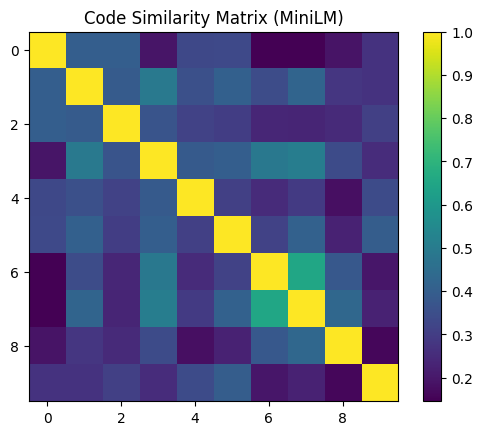

In [17]:
plt.imshow(similarities["MiniLM"], cmap="viridis")
plt.colorbar()
plt.title("Code Similarity Matrix (MiniLM)")
plt.show()


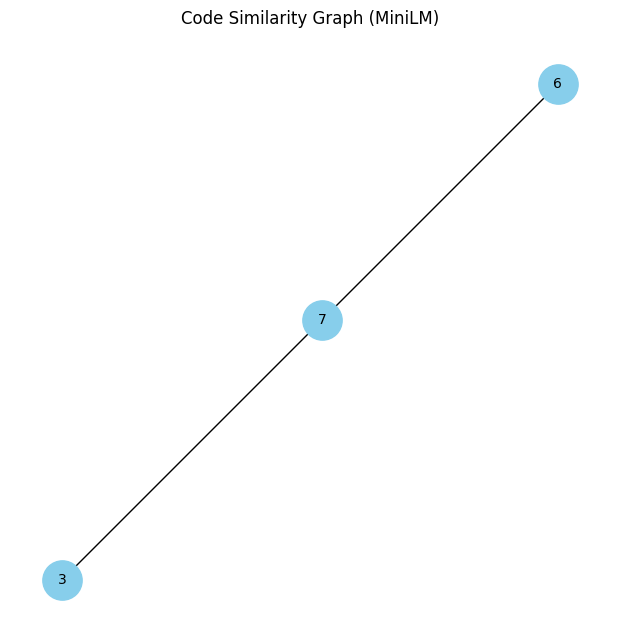

In [18]:
sim_matrix = similarities["MiniLM"]
G = nx.Graph()

for i in range(len(code_snippets)):
    for j in range(i+1, len(code_snippets)):
        if sim_matrix[i][j] > 0.5:  # threshold
            G.add_edge(i, j, weight=sim_matrix[i][j])

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color="skyblue", node_size=800, font_size=10)
plt.title("Code Similarity Graph (MiniLM)")
plt.show()
